# Big Data and Cloud Computing - Project 2 - Performance Analysis

This report focuses on the performance of several distributed computing frameworks: PySpark, Dask, Modin, JobLib, and Rapids. These libraries simplify the use of distributed computing, making it easier to handle big data processing and other computationally intense tasks. However, to use them effectively, it is important to understand the distributed computation paradigm, how each library implements this paradigm, the resources required for their use, and which library is best suited for specific user needs. In this report, we will discuss the advantages and disadvantages of each library and evaluate their performance in a specific case study.

### Quick overview about PySpark, Dask, Modin, JobLib and Rapids.

- PySpark: It is a Python API implementation for Apache Spark. It abstracts the parallel execution, the network communication for its execution in parallel and the allocation of computing resources. Based on "transformations" and "actions", the Apache Spark programming makes use of RDDs (Resilient Distributed Dataframes) to allocate data partitions across the nodes. During the "transformation" operations it creates RDDs and optimizes its execution plan in the distributed environment. The "action" operations execute the tasks modelled and collect the results for the end user. [1] The Spark session, which orchestrates the processes in the distributed environment, runs on top of a JVM (Java Virtual Machine), even when used as APIs in Python or R contexts it spawns a JVM [2].

- Dask: Dask is written in Python and only supports Python. It is based on Collections (entities whose task graphs are created based on), Task Graphs and Schedulers (orchestrates the execution of task graphs). The Dask graphs are lazily evaluated, meaning that they are only executed indeed when the compute() method is invoked. It has a Pandas-like syntax which makes it easier to understand when coming from a sequential programming background but with the capacity to manipulate large datasets. It can be easily converted from single node execution for distributed execution by the usage of dask.distributed module.[3]

- Modin: Modin is an easily "pluggable" engine that can scale the workflows of Pandas implementations for large datasets. Just as in Dask, it has a Pandas-like syntax that makes easy the conversion from a single-node execution to distributed executions. It covers ~90% of Pandas APIs. Differently from the Spark and Dask implementations which make use of lazy evaluation (create the graphs and RDDs and just execute the operations when it is explicitly triggered by the end-user), Modin implements the eager evaluation approach, like Pandas. Therefore, it performs all the computations as soon as it is issued. [4]

- JobLib: Joblib makes use of disk-caching and parallelism to optimize Python workflows. The caching mechanism avoids re-run costly operations, which in the end optimizes the big data workflows. It has helpers in the parallel code implementation, making it easy to write readable parallel code. [5]

- Rapids AI: Rapids is a library that makes use of GPU parallelism to accelerate some Data Science tasks like data preprocessing and implementation of Machine Learning models. It is built using NVIDIA CUDA and Apache Arrow. There are several interfaces implemented like Dataframe processing with cuDF (similar API to pandas), Machine learning with cuML (similar API to scikit-learn), Graph processing with cuGraph (similar API to networkX), Spatial analytics with cuSpatial (similar API to geoPandas), Image processing with cuCIM (similar API to scikit-image), Apache Spark acceleration with Spark RAPIDS, among others. [6]

### Experiment #1

## Materials and Methods

### Machines used and their characteristics

The infrastructure for experiment #1 was built on the Google Cloud Platform, using the Dataproc cloud service to construct a cluster with a native implementation of Apache Spark. Differently from the article  "Benchmark: Koalas (PySpark) and Dask", the study case compared the performance of PySpark (v3.2) and Dask (v2022.1.1), however, the operations analyzed were the same as the article.

The performance analysis was done by comparing two different infrastructures:

#### Single node execution:
  
Single Node (1 master, 0 workers)

Node type   | Machine types	|vCPUs*	|Memory (GB)|
------------|---------------|-------|-----------|
Master node |n2-standard-4	|4	    |16         |

#### Multi-node execution:
Standard (1 master, 2 workers)

Node type   | Machine types	|vCPUs*	|Memory (GB)|	
------------|---------------|-------|-----------|
Master node |n2-standard-4	|4	    |16         |
Worker nodes (x2) | n2-standard-2	|2|	8|


These machine types were selected mainly due to quota limitations (10 vCPUs). The dataset used in the benchmark was the [NYC Taxi and Limousine Commission (TLC) Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), with two different dataset sizes:
- smaller dataset: 1 file (yellow_tripdata_2023-12.parquet) with a total of 3376567 rows and ~56MB in compressed state;
- larger dataset: 4 files (yellow_tripdata_2023-12, yellow_tripdata_2024-1/2/3/4.parquet) with a total of 12931345 rows and ~217MB in compressed state.

During the benchmark execution, it was detected a limitation of 4 files as the largest dataset due to a blocking error in the execution with PySpark "function does not exist in JVM - ERROR". I did a lot of research to try to overcome the issue and could not find a solution. A possible approach could be to increase the memory in the cluster infrastructure and check if it solves the problem. I suspect it can be either a problem due to lack of memory during the execution - the error only occurs when I increase the dataset size (can JVM Garbage Collector be cleaning past data removing critical libraries from the execution context?) or a problem in the propagation of execution context across the nodes (at some point one of them misses a function and crashes).

To install Dask in the Dataproc cluster it was needed to set up the [initialization action](https://github.com/GoogleCloudDataproc/initialization-actions/blob/master/dask/README.md) provided by GCP Documentation with some adaptations. It was needed to replace the package manager from Conda to pip in the initialization shell script to overcome some issues in the package installation.

It was created a bucket to store all the data related to the benchmark. All the benchmark execution was done in a Jupyter Notebook interface running inside the Dataproc cluster.

The benchmark results evidence was taken from a single run, but during the project development, the same performance was consistent along the several runs.

### Results

In the benchmark in it was analysed the scenarios below:
- Standard operations (local & distributed execution)
- Operations with filtering (local & distributed execution)

The operations using caching and optimizations from Spark could not be performed due to quota limitations (limitation of Apache Spark optimization on Dataproc).

#### Results - Single node execution
>*note: Although in the Benchmark it is referenced as a local execution, it runs in GCP cloud service but with a single node*

**Smaller dataset = 1 file - a total of 3376567 rows and ~56MB in compressed state**

- In general, Dask had a better performance when compared with PySpark in almost all the standard operations, except the groupBy and join (join count) operations. The join operation seems to be an outlier for PySpark execution, and probably the time measured was only for the RDD creation and not the execution itself.
- For the operations with filtering the PySpark had a significant better performance in almost all the tasks.
- PySpark had an impressive poor performance column addition tasks and complex arithmetic tasks. After some research, it was found a ticket open for Apache Spark in version 3.4 reporting this poor performnace in kind of operations ([SPARK-45071](https://issues.apache.org/jira/browse/SPARK-45071) - Optimize the processing speed of `BinaryArithmetic#dataType` when processing multi-column data). However, I could not find a consistent cause for this poor performance. The code profile was done only for the sum operation in the distributed execution approach (more details commented later in this report).
- The addition of columns and complex arithmetic had poor performance, however the mean of these operations had a performance similar to Dask. Possibly the execution plan was optimized in the sequence of the RDD update.  



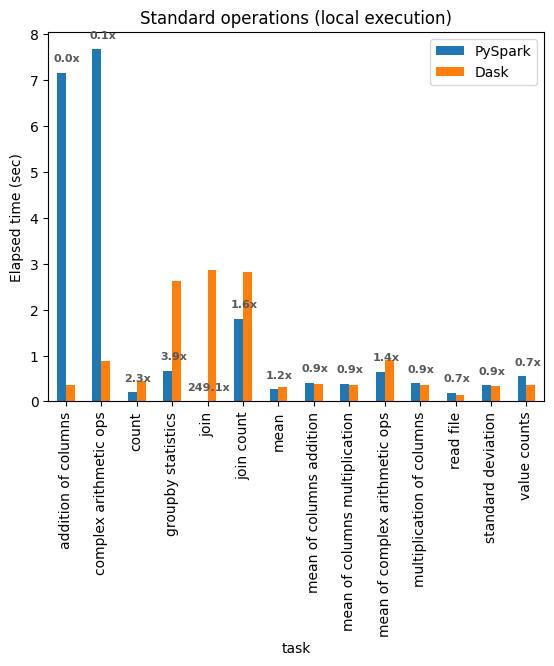

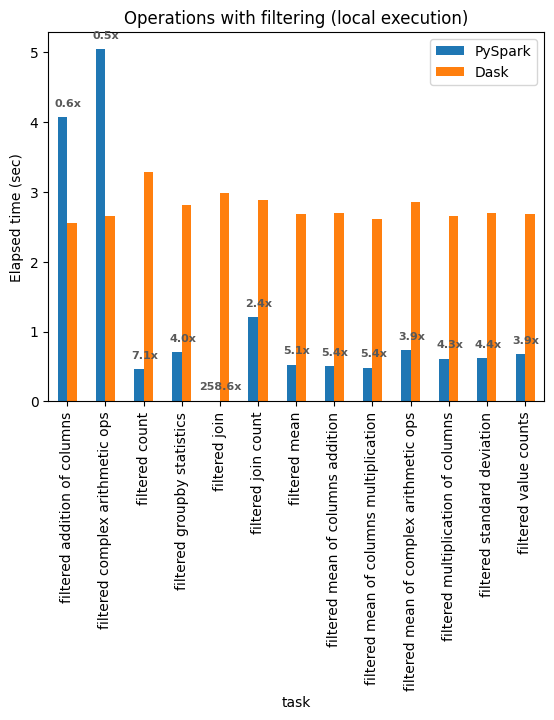

**Larger dataset = 4 files - a total of 12931345 rows and ~217MB in compressed state.**

The results are similar considering a bit larger dataset. 
- PySpark had overall a performance 5x times faster than Dask in the standard operations with filtering;
- However, for the standard operations, Dask had a better performance overall, except in the groupby and join count tasks.

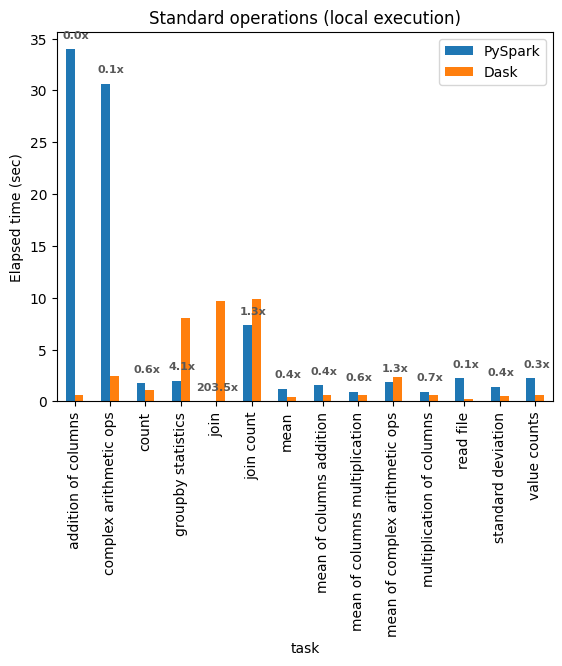

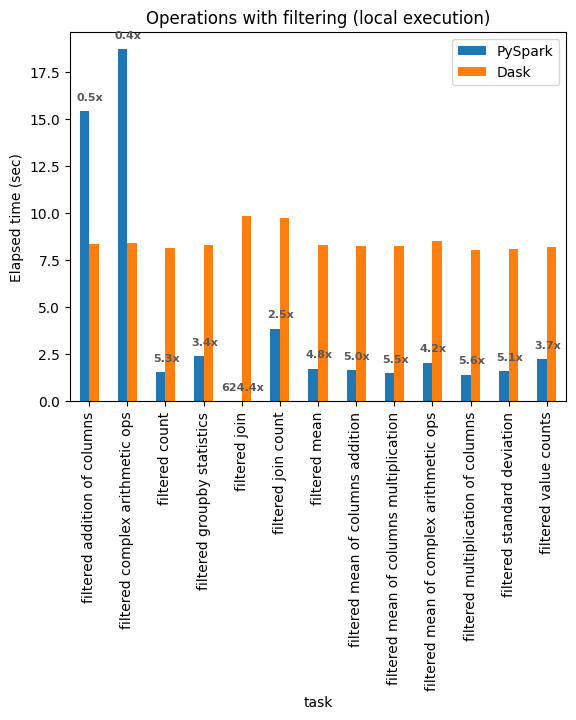

#### Results - Multi-node execution

**Smaller dataset = 1 file - a total of 3376567 rows and ~56MB in compressed state**


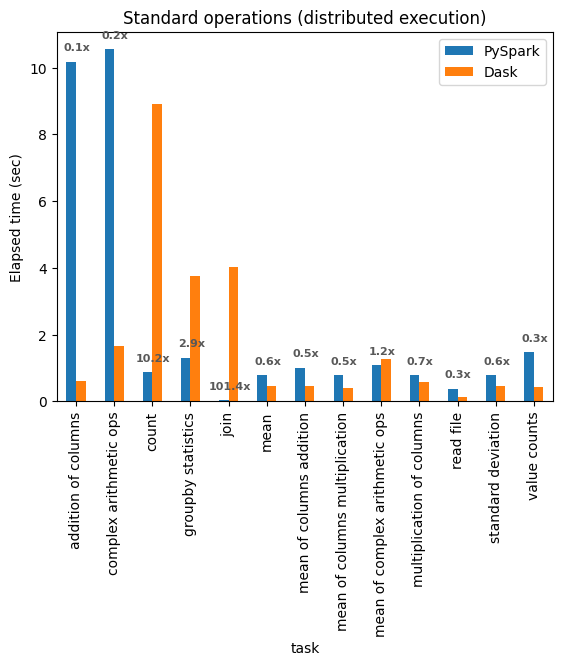

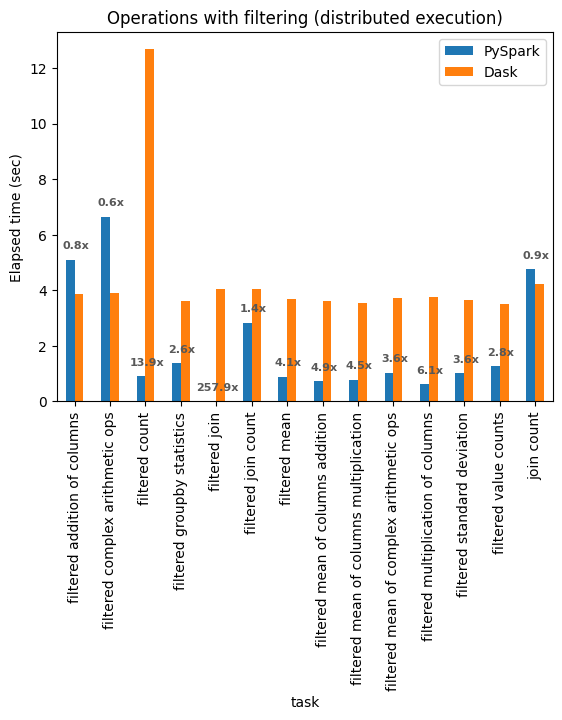

**Larger dataset = 4 files - a total of 12931345 rows and ~217MB in compressed state.**

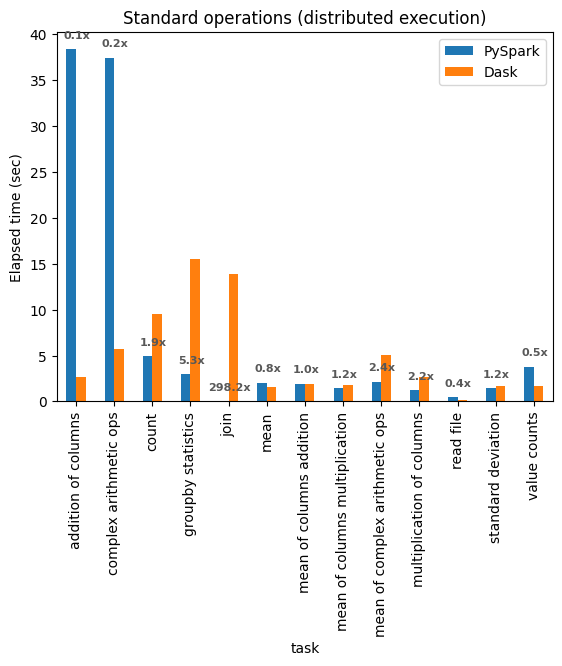

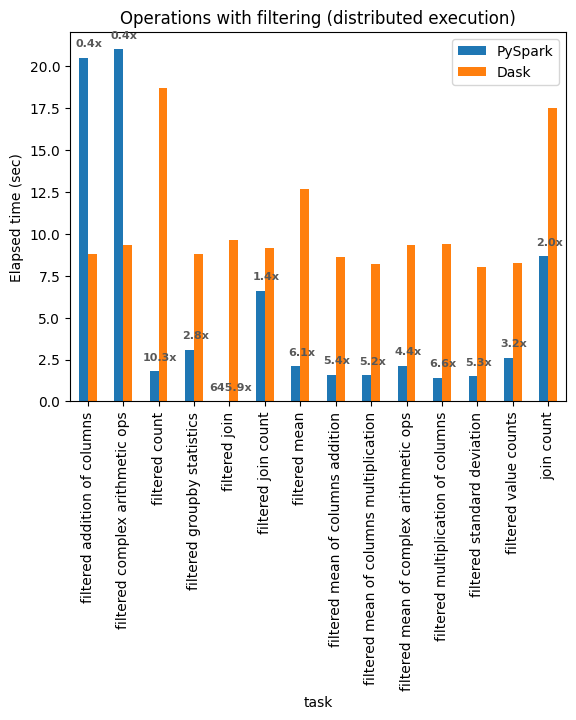

#### Profile the long time operations:

**Profile the addition of columns in filtered dataset**

In [ ]:
def sum_columns(df):
    result = df.select((col("fare_amount") + col("tip_amount")).alias("total_amount")).collect()
    return result

yappi.start()
sum_columns(pyspark_filtered)

# Stop profiling
yappi.stop()

# Get thread stats
thread_stats = yappi.get_thread_stats()
print("Thread Stats:")
thread_stats.print_all()

# Get function stats
func_stats = yappi.get_func_stats()
print("Function Stats:")
func_stats.print_all()

Thread Stats:

name   |        id  |   tid     |         ttot    |  scnt |
------------|-------|--------------|---------|------------|
_MainThread   | 0    |  139925494961984 | 571.3029 | 9049  |    
Thread        | 4    |  139923745007360 | 1.924969 | 1867  |    
Thread        | 3    |  139923155826432 | 0.830498 | 6541  |    
Thread        | 7    |  139924740839168 | 0.160554 | 1631  |    
Thread        | 5    |  139923147433728 | 0.135160 | 827   |   
Thread        | 6    |  139923139041024 | 0.128763 | 826   |    
Thread        | 1    |  139925429380864 | 0.094156 | 157   |    
..lizerWorker | 8    |  139924732446464 | 0.082299 | 895   |    
..tPollerUnix | 9    |  139924749231872 | 0.064662 | 826   |    
Thread        | 11   |  139925185877760 | 0.006549 | 40    |    
..avingThread | 2    |  139925169092352 | 0.004412 | 12    |    
ControlThread | 10   |  139925177485056 | 0.002049 | 4     |    

Function Stats:

Clock type: CPU
Ordered by: totaltime, desc

name                                  |ncall  |tsub      |ttot      |tavg    |  
--------------------------------------|-------|----------|---------|---------|
..:3511 ZMQInteractiveShell.run_code  |10   |  0.000324 | 571.2600 | 57.12600|
..dataframe.py:806 DataFrame.collect  |4     | 1.109416 | 567.9347 | 141.9837|
.. CloudPickleSerializer.load_stream  |682   | 0.005699 | 566.8098 | 0.831099|
..PickleSerializer._read_with_length  |682   | 0.009108 | 566.8041 | 0.831091|
..py:470 CloudPickleSerializer.loads  |678   | 0.005114 | 566.4870 | 0.835527|
..pyspark/sql/types.py:1729 <lambda>  |403.. | 59.95470 | 456.8897 | 0.000011|
..pes.py:811 StructType.fromInternal  |403.. | 92.49159 | 396.9350 | 0.000010|
.._3520/4205116474.py:17 sum_columns  |2   |   0.000096 | 284.9474 | 142.4737|
..2 complicated_arithmetic_operation  |2  |    0.000285 | 283.0256 | 141.5128|





Using Yappi to profile the code, the total time to process the addition of columns was about 570s using the code above.

#### Conclusion
In general, in distributed execution, the results were similar to the single node executions. However, we could notice that the PySpark performance improves as the dataset sizes increase. Although we could not reproduce the benchmark in large-scale data due to quota limitations, it was possible to notice that Dask showed better performance in standard operations without filtering when considering smaller datasets. With the dataset size increase, PySpark showed promising results and also had significantly better results when considering filtering in the operations.

### Experiment #2

Experiment #2 was run in the Google Colab notebook, using the default runtime. For this experiment, it was analysed the performance of different libraries in a complete Machine Learning (ML) workflow using both the XGBRegressor and Logistic Regression models. The analysis was done using the Yappi (Yet Another Python Profiler) to retrieve the Threads stats and Function stats. 

The dataset was a single file of the NYC Taxi Dataset (yellow_tripdata_2024-03.parquet). During the Pre-processing, it was done a random subsample with 100.000 observations without replacement.

It was decided to divide the ML workflow into 4 stages:

1. Total workflow time;;
2. Data Pre-processing;
3. XGBRegressor model;
4. Logistic Regression;
5. Test and evaluation.



#### Dask + Modin - Default Runtime

1. **Total workflow time**: 42,16 s;

2. **Data Pre-processing**: 5,58 s

The functions statistics were retrieved for the top 10 functions based on their execution time. It was possible to notice that the Pandas operations "where" and "getitem" had significant relative execution time (~38.56% in the longer run). About the Threads statistics, there were no relevant findings.


- Function 5:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4062 DataFrame.__getitem__
  Total Time: 2.151712772
  Number of Calls: 3
  Average Time per Call: 0.7172375906666667
- Function 6:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/generic.py:10803 DataFrame.where
  Total Time: 2.0945205380000003
  Number of Calls: 1
  Average Time per Call: 2.0945205380000003
- Function 7:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/generic.py:10615 DataFrame._where
  Total Time: 2.083190728
  Number of Calls: 1
  Average Time per Call: 2.083190728


3. **XGBRegressor**: 10.51 s

For the XGBRegressor model training, the main pain point was the GridSearchCV and not the model fitting itself. The XGBRegressor function was not listed in the top 10. The GridSearchCV was done using just 4 combinations of parameters and 5 folds. It was decided to use a few parameters to avoid the longer runs. The Cross-Validation took about 74% of the execution time for this stage.

- Function 5:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 7.857673945
  Number of Calls: 1
  Average Time per Call: 7.857673945
- Function 6:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1386 GridSearchCV._run_search
  Total Time: 7.58464499
  Number of Calls: 1
  Average Time per Call: 7.58464499
- Function 7:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:808 evaluate_candidates
  Total Time: 7.584574234000001
  Number of Calls: 1
  Average Time per Call: 7.584574234000001

4. **LogisticRegression**: 23.73s

For the Logistic Regression, the GridSearchCV was also costly. It was done with 3 distinct parameters and 5 folds. The Logistic Regression model fit was listed in the top 10 functions, with 1.37s per execution and 16 executions.  

- Function 3:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 23.646572836
  Number of Calls: 1
  Average Time per Call: 23.646572836
- Function 8:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1130 LogisticRegression.fit
  Total Time: 21.958873617000002
  Number of Calls: 16
  Average Time per Call: 1.3724296010625001
- Function 9:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1386 GridSearchCV._run_search
  Total Time: 21.715373965
  Number of Calls: 1
  Average Time per Call: 21.715373965
- Function 10:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:808 evaluate_candidates
  Total Time: 21.715301628000002
  Number of Calls: 1
  Average Time per Call: 21.715301628000002

5. **Test and Evaluation**: 2.45 s

The test and evaluation step was fast for the dataset selected, with the "classification_report" and the process of evaluation metrics taking about 49.79% of the execution time.

- Function 5:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2195 classification_report
  Total Time: 1.223304792
  Number of Calls: 1
  Average Time per Call: 1.223304792
- Function 6:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1406 precision_recall_fscore_support
  Total Time: 1.064801069
  Number of Calls: 4
  Average Time per Call: 0.26620026725
- Function 7:
  Name: /usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:138 unique
  Total Time: 0.993358598
  Number of Calls: 81
  Average Time per Call: 0.01226368639506173

#### Dask + RAPIDS

1. **Total workflow time**: 10.66 s
2. **Preprocessing**:  1.25 s

The top 1 function is from nvtx package, an component of RAPIDS framework that allows the execution using GPUs. 

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/nvtx/nvtx.py:113 inner
  Total Time: 0.5538226700000001
  Number of Calls: 1517
  Average Time per Call: 0.0003650775675675676

3. **XGBRegressor**: 978 ms

The GridSearch still being the function with higher execution time. However, it was much faster when using the GPUs to do so. 

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 0.787902863
  Number of Calls: 1
  Average Time per Call: 0.787902863

4. **Logistic Regression**: 7.12 s

The acceleration was not that fast for Logistic Regression model.

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 6.4441451480000005
  Number of Calls: 1
  Average Time per Call: 6.4441451480000005


5. **Test and evaluation**: 1.03 s

The functions listed are from cupy library. The time taken do perform the evaluation was about 1s.

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/cupy/cuda/compiler.py:471 _compile_module_with_cache
  Total Time: 0.9331032210000001
  Number of Calls: 5
  Average Time per Call: 0.18662064420000002
Function 2:
  Name: /usr/local/lib/python3.10/dist-packages/cupy/cuda/compiler.py:502 _compile_with_cache_cuda
  Total Time: 0.932909352
  Number of Calls: 5
  Average Time per Call: 0.18658187040000002

### Experiment #3

In experiment #3, the execution uses Pandas for a comparison with sequential execution. 

#### Pandas

1. **Total workflow time**: 45.31 s
2. **Preprocessing**:  8.01 s

The function which took more time in the preprocessing was the \__getitem\__. The listed functions took about 1s to complete, considering we had 10 functions listed, all of them with similar values, there is no single pain point in the execution. All the operations had almost the same execution time.

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:3713 DataFrame.__getitem__
  Total Time: 1.2689787750000001
  Number of Calls: 12
  Average Time per Call: 0.10574823125


Function 5:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:9980 DataFrame.corr
  Total Time: 1.213247274
  Number of Calls: 1
  Average Time per Call: 1.213247274

Function 9:
  Name: /usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:926 NumericBlock.take_nd
  Total Time: 1.1654468530000002
  Number of Calls: 10
  Average Time per Call: 0.11654468530000002

4. **XGBRegressor**: 16.1 s

   
Considering the top 10 functions, the GridSearch was the one which took more time to complete also in the sequential execution. The model fit was the 10th, taking 6.3s to complete (it is important to remember that the GridSearch performs several model fits during the best parameter search).

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 6.888995883000001
  Number of Calls: 1
  Average Time per Call: 6.888995883000001

Function 10:
  Name: /usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:969 XGBRegressor.fit
  Total Time: 6.303367239
  Number of Calls: 21
  Average Time per Call: 0.3001603447142857

5. **Logistic Regression**: 19 s

For the Logistic Regression approach, the GridSearchCV was also costly and took almost all the execution time.

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:737 GridSearchCV.fit
  Total Time: 16.609687649
  Number of Calls: 1
  Average Time per Call: 16.609687649

Function 6:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1130 LogisticRegression.fit
  Total Time: 15.607970393
  Number of Calls: 16
  Average Time per Call: 0.9754981495625

6. **Test and evaluation**: 2.2 s

In general, the test and evaluation were fast. The classification report generation was the operation that took more time to complete.

Function 1:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2195 classification_report
  Total Time: 0.65119401
  Number of Calls: 1
  Average Time per Call: 0.65119401
Function 2:
  Name: /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1406 precision_recall_fscore_support
  Total Time: 0.59055164
  Number of Calls: 4
  Average Time per Call: 0.14763791



### Comparing results from experiment #3

Experiment 3 was done using the NYC Dataset with a subsample of 100.000 rows. The executions were all done in Google Colab.
 
|Runtime           |Total execution time |Preprocessing |XGBRegressor |Logistic Regression |Test and evaluation |
-------------------|---------------------|--------------|-------------|--------------------|--------------------|
Dask + Modin       |42,16 s              |5,58 s        |10.51 s      |23.73s              |2.45 s              |
Dask + RAPIDS      |10.66 s              |1.25 s        |978 ms       |7.12 s              |1.03 s              |
Pandas             |45.31 s              |8.01 s        |16.1 s      |19 s                 |2.2 s               |

## Conclusion and results

It is clear the difference in performance when comparing the listed runtimes, being RAPIDS the faster to serve the results by far. With the profile results, it was possible to notice that GridSearchCV is costly and takes significant time to complete. In general, the Logistic Regression had higher response times. When using RAPIDS we had a promising result in all the operation types listed. Using the Yappi profiler we don't profile the GPU usage, just the CPU. From these results, we can understand that the usage of RAPIDS in data workflows can be helpful, but it is necessary to have GPU integrated into the infrastructure. When comparing Dask and Pandas the difference in performance was not expressive. However, it is important to remember the dataset size. Possibly in larger datasets the difference between the Dask and Pandas' performance could be more significant. 

References: 
[1] https://cacm.acm.org/research/apache-spark/ 
[2] https://moodle2324.up.pt/pluginfile.php/242215/mod_resource/content/1/bdcc_spark_arch.pdf
[3] https://docs.dask.org/en/latest/10-minutes-to-dask.html
[4] https://modin.readthedocs.io/en/latest/getting_started/why_modin/modin_vs_dask_vs_koalas.html
[5] https://joblib.readthedocs.io/en/stable/
[6] https://rapids.ai/learn-more/#about

